# El paquete Astropy
Es un paquete de Python diseñado específicamente para la astromía/astrofísica.

Algunos de los módulos más utilizados son:

* Units
* Coordinates
* Table

In [1]:
from astropy import units as u 
from astropy.coordinates import SkyCoord  

from astropy.table import Table
from astropy.io import fits

In [2]:
#- Otros módulos
import matplotlib.pyplot as plt

## Trabajando con unidades físicas

In [3]:
#- Distancia a una estrella
distance = 1 * u.kpc

#- Distancia equivalente en metros:
distance.to(u.m)

<Quantity 3.08567758e+19 m>

In [4]:
#- Unidades de distancia
distance_units = ['cm', 'm', 'km', 'lyr', 'pc', 'nm', 'au']

#- Distancia equivalente en varias unidades
print(f'{distance} es equivalente a:\n=========================')

for unit in distance_units:
    print( distance.to(u.Unit(unit)) )

1.0 kpc es equivalente a:
3.0856775814913673e+21 cm
3.085677581491367e+19 m
3.085677581491367e+16 km
3261.5637771674333 lyr
1000.0 pc
3.085677581491367e+28 nm
206264806.24709633 AU


In [5]:
velocity = 60 *u.km/u.h
velocity

<Quantity 60. km / h>

In [6]:
velocity.to(u.m/u.s)

<Quantity 16.66666667 m / s>

## Trabajando con coordenadas celestes

In [7]:
#- Coordenadas ecuatoriales en grados
coord = SkyCoord(ra=10.684*u.degree, dec=41.269*u.degree, frame='icrs')

#- Equivalente en horas-minutos-segundos
print(coord.to_string('hmsdms'))

00h42m44.16s +41d16m08.4s


## Trabajando con tiempos

In [8]:
from astropy.time import Time

# Una fecha cualquiera
t = Time('2024-07-15T12:34:56', format='isot', scale='utc')

# Julian Date
print(t.jd)

2460507.0242592595


## Trabajando con tablas
Con astropy se pueden leer tablas casi en cualquier formato. Un formato muy popular en astronomía son los archivos con extensión fits (**F**lexible **I**mage **T**ransport **S**ystem). 

El módulo `Table` de `astropy.table` permite leer este tipo de archivos.

Las imágenes CCD se almacenan en archivos `.fits`. Sin embargo, no es posible leerlas con `Table`. 

Para poder trabajar con ellas, haremos uso del módulo `fits` de `astropy.io`.

Puedes encontrar las imágenes siguientes en este enlace de Google drive: https://drive.google.com/drive/folders/1TxopD_fIa1ZHplm_SH0Gvhe663psuJn-?usp=sharing

In [9]:
#- Ruta a la ubicación de los datos
bias_image   = '../Talleres/Binary-system/OB0001/bias/0002611406-20200712-OSIRIS-OsirisBias1.fits'
flat_image   = '../Talleres/Binary-system/OB0001/flat/0002615401-20200712-OSIRIS-OsirisSkyFlat1.fits'
object_image = '../Talleres/Binary-system/OB0001/object/0002611437-20200712-OSIRIS-OsirisBroadBandImage1.fits'

In [10]:
#- Leyendo la imagen con astropy
bias_data   = fits.open(bias_image)[0]
flat_data   = fits.open(flat_image)[0]
object_data = fits.open(object_image)[0]

In [11]:
#- Leyendo la información de la imagen
bias_data.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1049 / Axis length                                    
NAXIS2  =                 2051 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2021-10-07T01:52:03' / Date FITS file was generated                  
IRAF-TLM= '2021-10-07T01:52:03' / Time of last modification                     
OBJECT  = 'BIAS    '           / Name of the object observed                    
ORIGFILE= 'Jul12_204354.fits

In [12]:
#- Accediendo a los datos de la imagen
bias_data.data

array([[1039, 1137, 1156, ..., 1203,   29,  881],
       [1037, 1133, 1171, ..., 1192,   28,  892],
       [1044, 1135, 1170, ..., 1204,   29,  896],
       ...,
       [1069, 1160, 1184, ..., 1224,   28,  897],
       [1062, 1157, 1180, ..., 1231,   29,  892],
       [1068, 1160, 1188, ..., 1221, 1224,  102]], dtype=uint16)

In [13]:
#- Propiedades de la imagen
bias_data.data.shape

(2051, 1049)

### Visualizando la imagen
Los datos son un arreglo de dos dimensiones. Podemos intentar visualizarlos usando `plt.imshow()`:

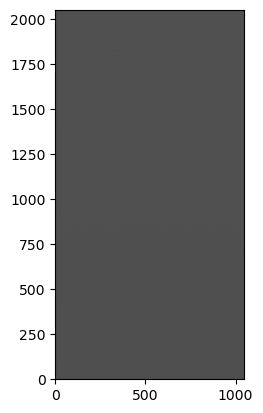

In [14]:
plt.imshow(bias_data.data, cmap='gray', origin='lower')
plt.show()

Es un arreglo de $2051\times 1049$, se necesita escalar para visualizarlo mejor.

Podemos usar la siguiente función, que a su vez utiliza otros módulos de astropy:

In [15]:
from astropy.nddata.blocks import block_reduce
from astropy import visualization as aviz

def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()
    
    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio
    
    reduced_data = block_reduce(image, ratio)
    
    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2
    
    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

Recomiendo guardar la función anterior, ya que la usaremos con mucha frecuencia.

Intentemos visualizar los datos nuevamente:

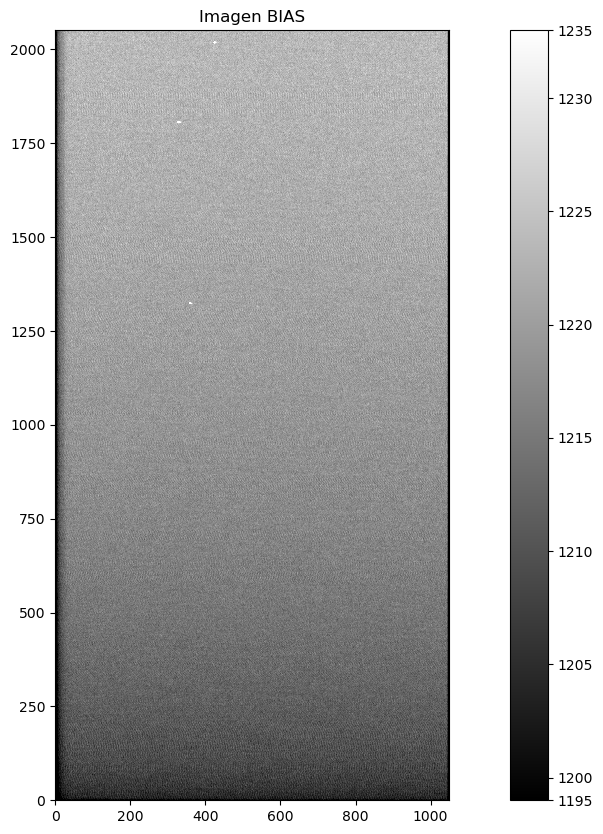

In [16]:
show_image(bias_data.data, cmap='gray')
plt.title('Imagen BIAS')
plt.show()

Y ahora veamos la imagen flat:

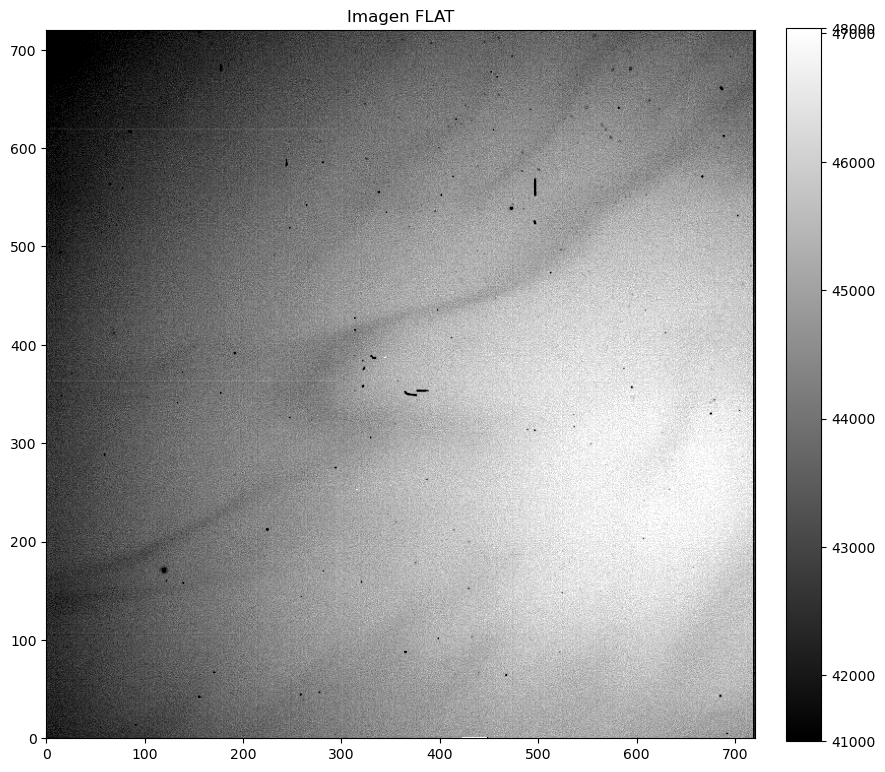

In [17]:
show_image(flat_data.data, cmap='gray')
plt.title('Imagen FLAT')
plt.show()

Y la imagen del objeto:

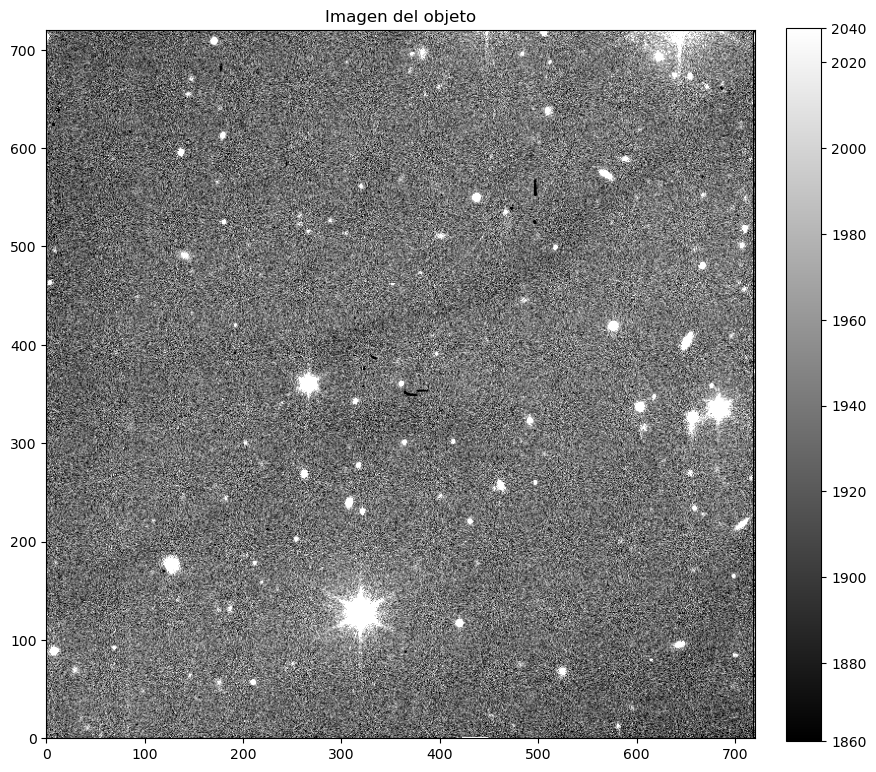

In [18]:
show_image(object_data.data, cmap='gray')
plt.title('Imagen del objeto')
plt.show()

In [19]:
import image_sim as imsim
import numpy as np


In [20]:
image = np.zeros([2000, 2000])
noise = 1500

stars_with_noise = imsim.stars(image, 50, max_counts=2000, fwhm=10) + imsim.read_noise(image, noise)

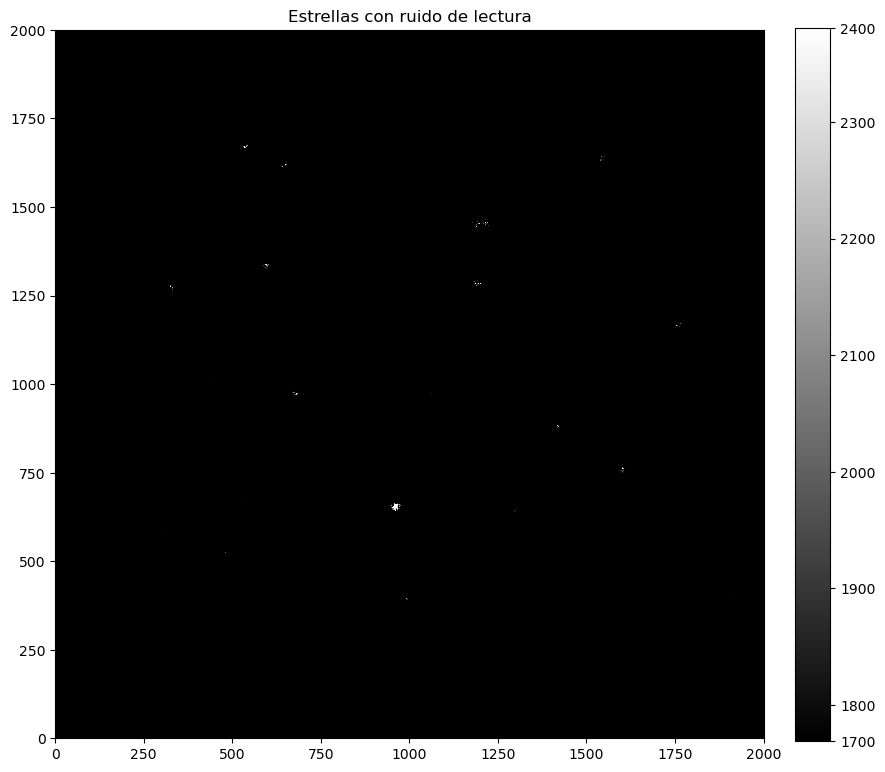

In [21]:
show_image(stars_with_noise, cmap='gray', percu=99.9)
plt.title('Estrellas con ruido de lectura')
plt.show()

In [22]:
read_noise = imsim.read_noise(image, noise)
new_stars = stars_with_noise - read_noise

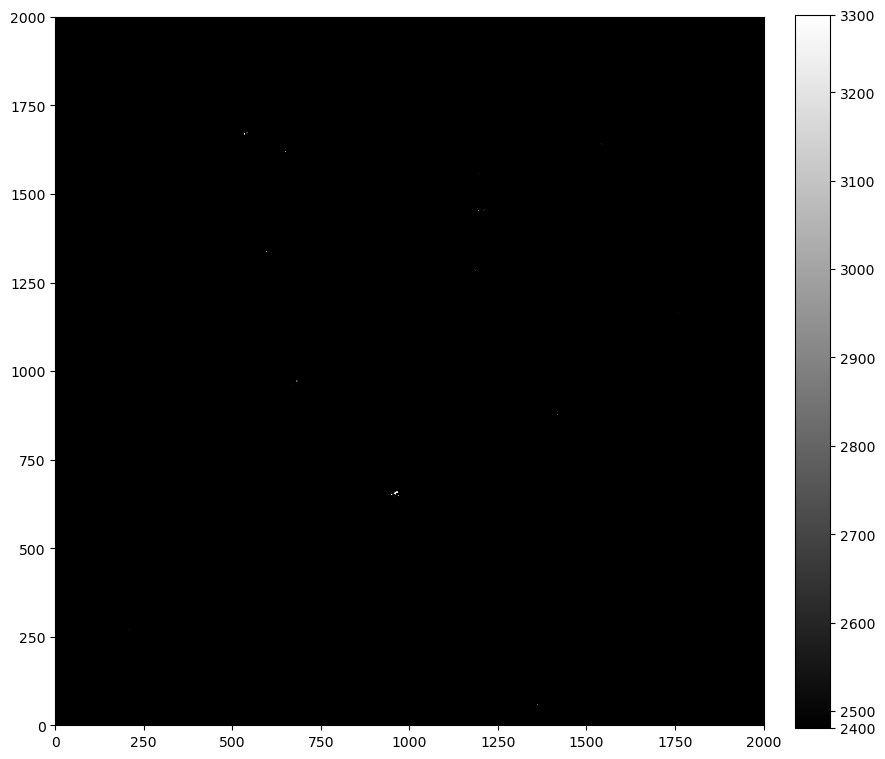

In [23]:
show_image(new_stars, cmap='gray', percu=99.9)
plt.show()

# Otro intento de limpiar la imagen

In [24]:
stars_exposure = 30.0
dark_exposure = 60.0
dark = 0.1
sky_counts = 20
bias_level = 1100
read_noise = 700
max_stars_counts = 2000

In [25]:
bias_with_noise = (imsim.bias(image, bias_level, realistic=True) + 
                   imsim.read_noise(image, read_noise))

dark_frame_with_noise = (imsim.bias(image, bias_level, realistic=True) + 
                         imsim.dark_current(image, dark, dark_exposure, hot_pixels=True) +
                         imsim.read_noise(image, read_noise))

flat = imsim.sensitivity_variations(image)

In [26]:
realistic_stars = (imsim.stars(image, 50, max_counts=max_stars_counts) +
                   imsim.dark_current(image, dark, stars_exposure,  hot_pixels=True) +
                   imsim.bias(image, bias_level, realistic=True) +
                   imsim.read_noise(image, read_noise)
                  )

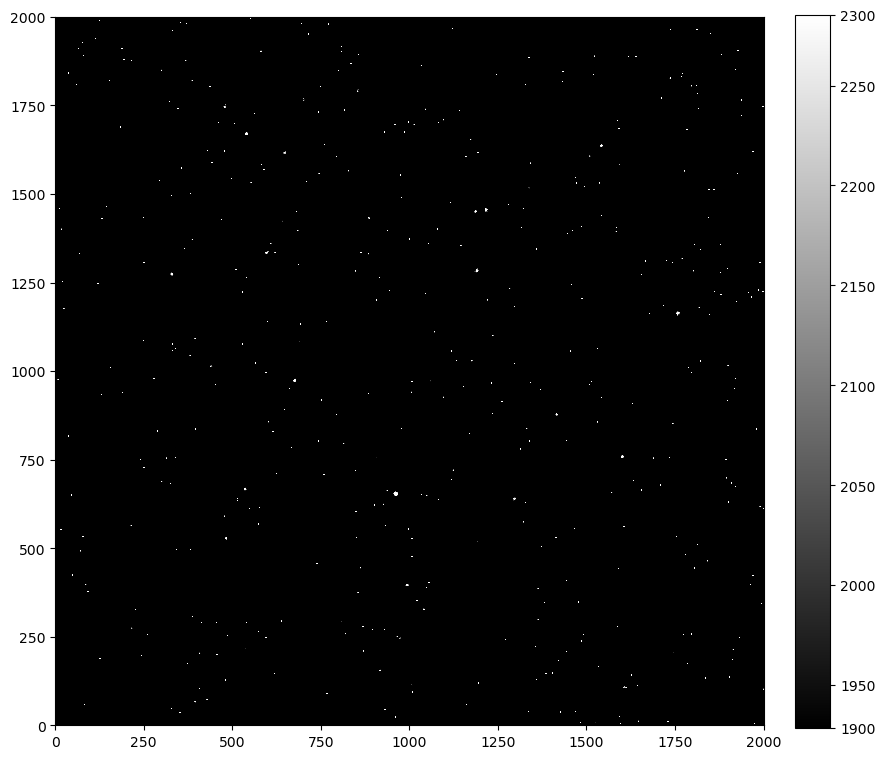

In [28]:
show_image(realistic_stars, cmap='gray', percu=99.9)
plt.show()

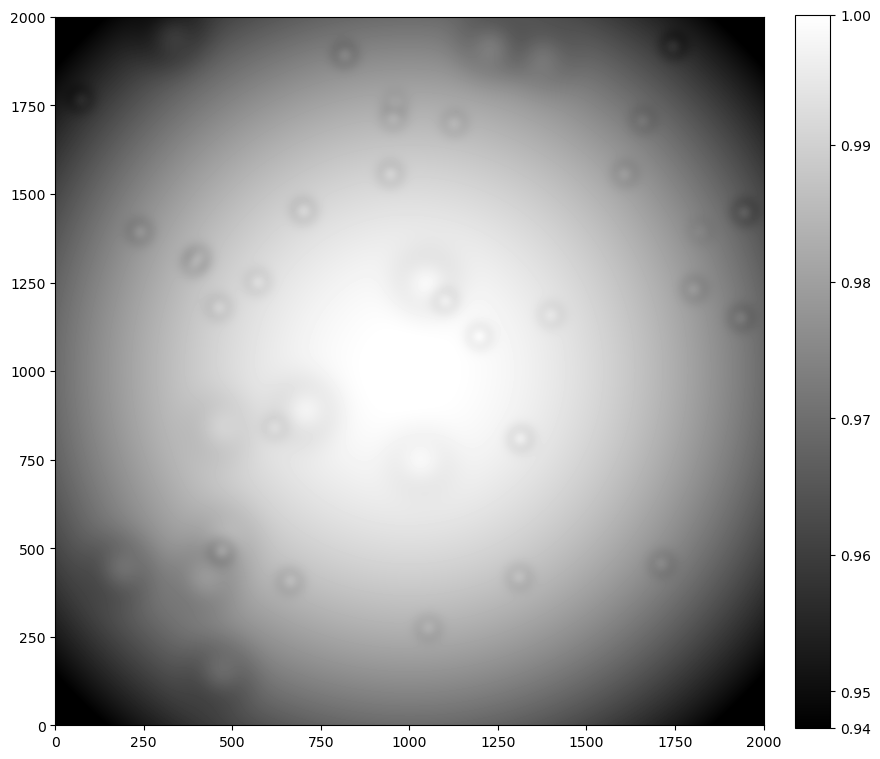

In [29]:
show_image(flat, cmap='gray')

In [30]:
scaled_dark_current = stars_exposure * (dark_frame_with_noise - bias_with_noise) / dark_exposure

In [31]:
calibrated_stars = (realistic_stars - bias_with_noise - scaled_dark_current) / flat

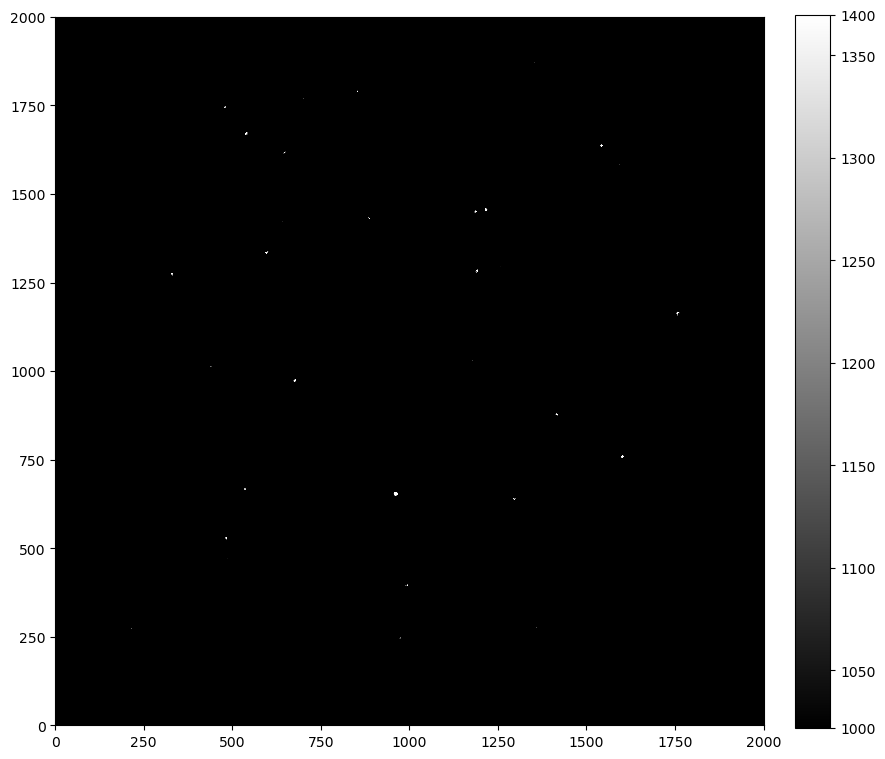

In [32]:
show_image(calibrated_stars, cmap='gray', percu=99.9)
plt.show()

In [33]:
from astropy.visualization import hist

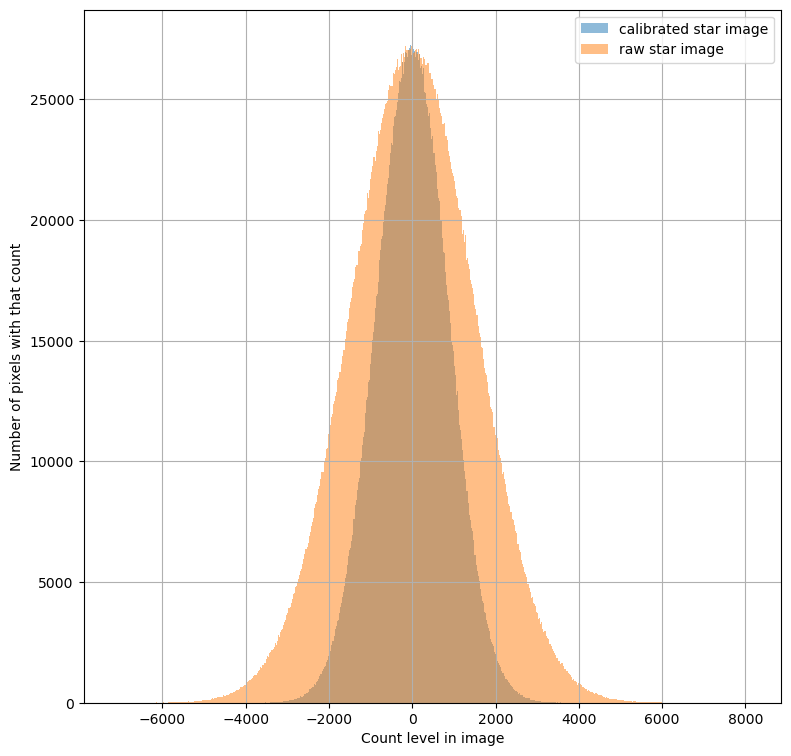

In [34]:
plt.figure(figsize=(9, 9))
hist(calibrated_stars.flatten(), bins='freedman', label='calibrated star image', alpha=0.5)
hist(stars_with_noise.flatten(), bins='freedman', label='raw star image', alpha=0.5)
plt.legend()
plt.grid()
plt.xlabel('Count level in image')
plt.ylabel('Number of pixels with that count')